In [36]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# %% importa i moduli
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import tensorflow as tf
import statistics
from scipy.stats import invgauss

In [3]:
# %% download e caricamento del file .npz contenente il dataset
!wget https://politecnicobari-my.sharepoint.com/:u:/g/personal/marco_scarpetta_poliba_it/EWPUBcglPk9Iigof03DZ86gB2Lx8KK8bFCSEbYSXE4KyCQ?download=1 -O /content/lines.npz
data = np.load('/content/lines.npz')

# lunghezza del lato delle immagini in pixel
img_size = 64

--2021-01-19 18:08:11--  https://politecnicobari-my.sharepoint.com/:u:/g/personal/marco_scarpetta_poliba_it/EWPUBcglPk9Iigof03DZ86gB2Lx8KK8bFCSEbYSXE4KyCQ?download=1
Resolving politecnicobari-my.sharepoint.com (politecnicobari-my.sharepoint.com)... 52.105.138.27
Connecting to politecnicobari-my.sharepoint.com (politecnicobari-my.sharepoint.com)|52.105.138.27|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/marco_scarpetta_poliba_it/Documents/data/esempi/lines.npz?originalPath=aHR0cHM6Ly9wb2xpdGVjbmljb2JhcmktbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvbWFyY29fc2NhcnBldHRhX3BvbGliYV9pdC9FV1BVQmNnbFBrOUlpZ29mMDNEWjg2Z0IyTHg4S0s4YkZDU0ViWVNYRTRLeUNRP3J0aW1lPWVXR1RMNlc4MkVn [following]
--2021-01-19 18:08:12--  https://politecnicobari-my.sharepoint.com/personal/marco_scarpetta_poliba_it/Documents/data/esempi/lines.npz?originalPath=aHR0cHM6Ly9wb2xpdGVjbmljb2JhcmktbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvbWFyY29fc2NhcnBldHRhX3BvbGliYV9pdC9FV1BVQmNnbFB

In [4]:
# %% lista degli array contenuti nel file del dataset
list(data.keys())

['training_images',
 'training_labels',
 'validation_images',
 'validation_labels']

In [5]:
# %% dimensioni dell'array contenente le immagini di training
data['training_images'].shape

(50000, 64, 64)

In [6]:
# %% dimensioni del vettore dei label di training
# questo array contiene le lunghezze delle linee presenti in ogni immagine del
# training set 
data['training_labels'].shape

(50000,)

In [7]:
# %% preparazione del dataset
## caricamento delle lunghezze delle linee in pixel
training_labels_px = data['training_labels']
validation_labels_px = data['validation_labels']

# unione dei label di training e validazione in un unico array
labels_px = np.hstack([training_labels_px, validation_labels_px])

# calcolo dei valori minimi e massimi delle lunghezze
labels_px_min = np.min(labels_px)
labels_px_max = np.max(labels_px)
labels_px_range = labels_px_max - labels_px_min

# label normalizzati nell'intervallo [0, 1]
training_labels = training_labels_px / labels_px_range
validation_labels = validation_labels_px / labels_px_range

print(np.max(training_labels))
print(np.max(training_labels_px/labels_px_range))


## caricamento degli array contenenti le immagini in nuove variabili
training_images = data['training_images']
validation_images = data['validation_images']

1.1719097743930944
1.1719097743930944


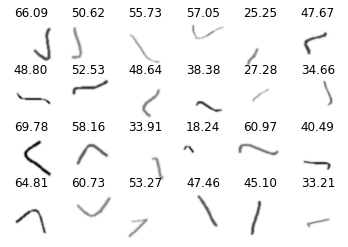

In [8]:
# %% visualizzazione di alcuni esempi presenti nel dataset di training
rows = 4
cols = 6

# primo campione da mostrare
start = 1000

for i in range(rows * cols):
    plt.subplot(rows, cols, i + 1)
    img = training_images[start + i]
    plt.imshow(img, cmap='Greys', vmin=0, vmax=1)
    plt.axis('off')
    plt.title('{:.2f}'.format(training_labels_px[start + i]))
plt.show()

In [9]:
# %% costruzione della rete neurale per la misura della lunghezza della linea
# presente in ogni immagine

inputs = tf.keras.Input(shape = (img_size, img_size))

# aggiunge un asse al tensore di ingresso, perché richiesto del layer Conv2D
x = tf.keras.layers.Reshape([img_size, img_size, 1])(inputs)

# sequenza di layer convoluzionali con attivazione 'relu'
# (classe tf.keras.layers.Conv2D) seguiti da max pooling
# (classe tf.keras.layers.MaxPool2D)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D() (x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D() (x)
x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D() (x)

x = tf.keras.layers.Flatten() (x)

x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid') (x)


# layer per appiattire il tensore (classe tf.keras.layers.Flatten)

# layer densamente connesso (classe tf.keras.layers.Dense)

# layer d'uscita con un solo neurone e attivazione 'sigmoid'
# (classe tf.keras.layers.Dense)

# inizializzazione della classe tf.keras.Model, con argomenti gli ingressi e le
# uscite del modello
model = tf.keras.Model(inputs, x)

loss_fn = tf.keras.losses.MSE

model.compile('adam', loss=loss_fn,
              metrics=['accuracy'])

model.summary()


# compilazione del modello con il metodo compile
# specificare come primo argomento l'ottimizzatore 'adam'
# scegliere una loss function adatta al problema di regressione
# che si vuole analizzare

# stampa un sommario del modello con il metodo summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856 

In [10]:
# %% training
# early stopping: ferma il training se la validation loss non scende per 10
# epoche
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

history = model.fit(training_images, training_labels,
                    validation_data=(validation_images, validation_labels),
                    epochs=100, callbacks=early_stopping)

Epoch 1/100
1563/1563 [==============================] - 17s 6ms/step - loss: 0.0088 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 2/100
1563/1563 [==============================] - 9s 6ms/step - loss: 8.9402e-04 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 3/100
1563/1563 [==============================] - 9s 6ms/step - loss: 8.3700e-04 - accuracy: 0.0000e+00 - val_loss: 9.8294e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
1563/1563 [==============================] - 9s 6ms/step - loss: 7.1114e-04 - accuracy: 0.0000e+00 - val_loss: 9.1758e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
1563/1563 [==============================] - 9s 6ms/step - loss: 4.9086e-04 - accuracy: 0.0000e+00 - val_loss: 5.8952e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1563/1563 [==============================] - 9s 6ms/step - loss: 4.3018e-04 - accuracy: 0.0000e+00 - val_loss: 3.0989e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
1563/1563 [======================

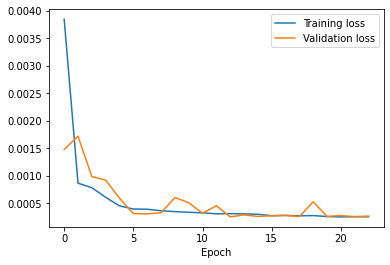

In [11]:
# grafico del processo di training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

In [38]:
# salva i pesi del modello nel file cifar10.h5, in una cartella di google drive
model.save_weights('/content/gdrive/My Drive/AI/pesi.h5')

# per caricare i pesi dal file, dopo aver creato il modello, si usa:
model.load_weights('/content/gdrive/My Drive/AI/pesi.h5')

In [22]:
# %% stima delle lunghezze delle linee nelle immagini del validation set
# utilizzate il metodo predict dell'oggetto model
validation_labels_hat = model.predict(validation_images)

# conversione delle stime normalizzate in pixel
validation_labels_hat_px = validation_labels_hat * labels_px_range

validation_labels_hat_px = np.ndarray.flatten(validation_labels_hat_px)

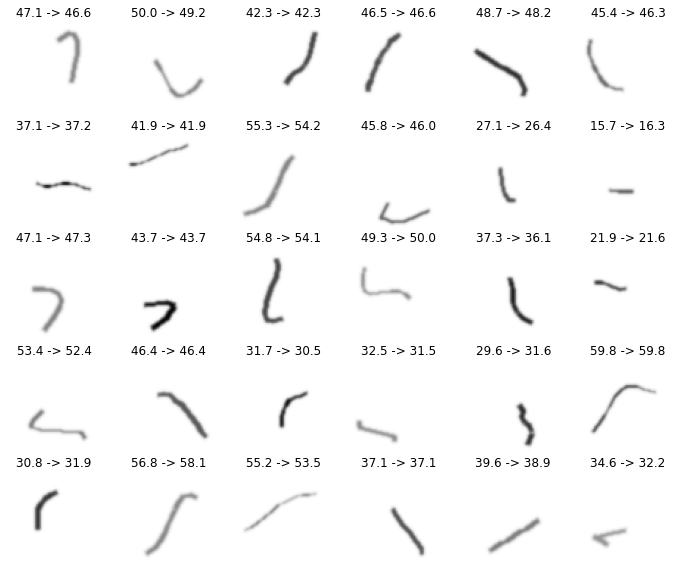

In [23]:
# %% visualizzazione delle stime per alcuni esempi del dataset di validazione
rows = 5
cols = 6

# primo campione da mostrare
start = 1000

plt.figure(figsize=(12,10))
for i in range(rows * cols):
    plt.subplot(rows, cols, i + 1)
    img = validation_images[start + i]
    plt.imshow(img, cmap='Greys', vmin=0, vmax=1)
    plt.axis('off')
    plt.title('{:.1f} -> {:.1f}'.format(
        validation_labels_px[start + i],
        validation_labels_hat_px[start + i]))
plt.show()

0.19091588170281149
1.109079094103181
2.1737950244422346


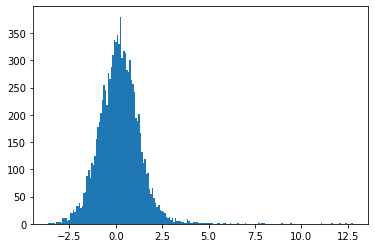

In [35]:
# %% analisi degli errori e calcolo incertezze
# vettori degli errori commessi nella stima delle lunghezze del dataset di
# validazione

# definizione dell'errore
e = validation_labels_px - validation_labels_hat_px

# stampa della distribuzione dell'errore
plt.hist(e, 200)

# calcolo del bias dell'errore
media = np.average(e)
print(media)

#calcolo dell'incertezza standard 
sigma = np.std(e)
print(sigma)

# calcolo e stampa dell'incertezza estesa con una assegnata probabilità di
# copertura

# calcolo incertezza estesa con probabilità di copertura cp = 95% e quindi k = 1.96

U95 = 1.96*sigma
print(U95)

In [32]:
# calcolo incertezza di caso peggiore. Non riesco a ricavare l'incertezza standard di qui perchè la distribuzione non è simetrica e non è unifome
U100 = np.max(e)
print(U100)
U100esk = np.min(e)
print(U100esk)

12.778087652878426
-3.6344488674461317
